<div align="center">
<h1 style="color:#1565c0; font-size:2.8em; font-weight:bold; margin-bottom:0.2em; margin-top:0.5em;">Практична робота №2</h1>
<h3 style="color:#1976d2; margin-top:0; font-weight:normal;">Побудова та оцiнювання якостi
моделей класифiкацiї та регресiї засобами бiблiотеки <b>Scikit-Learn Python</b></h3>
<br>
<br>
<b>Варіант 12</b><br>
<b>Автори:</b><br>
Плахтій Злата, КА-32<br>
Пастушенко Максим, КА-33<br>
Романов Фелікс, КА-33
</div>

<b>Мета:</b> Метою роботи є побудова та оцiнювання якостi моделей:
- дерев рiшень,
- опорних векторiв,
- логiстичної регресiї,
- наївної баєсiвської моделi
для класифiкацiї та регресiї засобами бiблiотеки Scikit-Learn Python.

<b>Хід роботи:</b>
1. Підготувати дані.
2. Представити початкових даних графiчно.
3. Розбити данi на навчальний та валiдацiйний набори.
4. Побудувати на навчальному наборi даних моделi класифiкацiї або регресiї заданi згiдно з варiантом.
4. Представити моделi графiчно (наприклад вивести частину дерева рiшень, побудувати лiнiю регресiї тощо).
5. Виконати прогнози на основi побудованих моделей.
6. Для кожної з моделей оцiнити, чи має мiсце перенавчання.
7. В задачах регресiї розрахувати для кожної моделi наступнi критерiї якостi, окремо на навчальнiй та валiдацiйнiй множинах:

    • коефiцiєнт детермiнацiї R2,
    
    • помилки RMSE, MAE та MAPE.

8. Спробувати виконати решiтчастий пошук (grid search) для пiдбору гiперпараметрiв моделей.
9. Зробити висновки про якiсть роботи моделей на дослiджених даних. На
основi критерiїв якостi спробувати обрати найкращу модель.
10. Навчити моделi на пiдмножинах навчальних даних. Оцiнити, наскiльки
розмiр навчальної множини впливає на якiсть моделi.
11. Кожний варiант мiстить два набори даних. Дослiдити обидва набори за
наведеними вище етапами.

<b>Завдання:</b><br>
Побудувати моделi регресiї на основi методу опорних векторiв:<br><br>
• Моделi нелiнiйної регресiї SVR(kernel="poly") з полiномiальним ядром. <br>
  Розглянути полiноми рiзного ступеня degree та рiзнi комбiнацiї гiперпараметрiв epsilon i C, наприклад: epsilon=0.1 i C=0.01; epsilon=0.1 i C=100.<br><br>
• Настроїти гiперпараметри epsilon i C, використовуючи решітчастий пошук.<br><br>
Початковi данi:<br>
(б) [avocado_prices.csv](https://www.kaggle.com/datasets/neuromusic/avocado-prices)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from sklearn.preprocessing import RobustScaler, StandardScaler

In [2]:
# ------------------------------
# 1.1. Завантаження та огляд даних
# ------------------------------

# Load
df = pd.read_csv('data/avocado.csv')
df.columns = df.columns.str.strip()

# Header
print(f"Rows: {df.shape[0]:,}  |  Cols: {df.shape[1]:,}  |  Memory: {df.memory_usage(deep=True).sum()/1024**2:.3f} MB")
print("Columns:", ", ".join(df.columns))

# Types + non-null + unique (compact)
info = pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "non_null": df.notna().sum(),
    "unique": df.nunique(dropna=False)
})
print("\nTypes / non-null / unique:")
print(info.to_string())

# Quick peek
print("\nHead:")
print(df.head().to_string(index=False))

# Numeric descriptive (compact)
num = df.select_dtypes(include=[np.number])
if not num.empty:
    print("\nNumeric summary:")
    print(num.describe().T.loc[:, ["count","mean","std","min","50%","max"]].to_string(float_format="{:,.3f}".format))

# Missing values
miss = df.isna().sum()
miss = miss[miss>0].sort_values(ascending=False)
print("\nMissing values:")
if miss.empty:
    print("  None")
else:
    pct = (miss/len(df)*100).round(2)
    for c in miss.index:
        print(f"  {c}: {miss[c]} ({pct[c]}%)")

# Duplicates
dups = df.duplicated().sum()
print(f"\nDuplicate rows: {dups}")
if dups:
    print("  First duplicates:")
    print(df[df.duplicated(keep='first')].head(3).to_string(index=False))

# Date parsing
if 'Date' in df.columns:
    parsed = pd.to_datetime(df['Date'], errors='coerce')
    bad = parsed.isna().sum()
    print(f"\nDate column: original dtype={df['Date'].dtype}, parse_failures={bad}")
    if bad==0:
        print(f"  Date range: {parsed.min().date()} — {parsed.max().date()}")
    else:
        print("  Example unparsable Date values:")
        print(df.loc[parsed.isna(), 'Date'].drop_duplicates().head(5).to_string(index=False))

# Quick numeric sanity checks
neg = [(c,int((df[c]<0).sum())) for c in num.columns if (df[c]<0).any()]
if neg:
    print("\nNegative values found:")
    for c,n in neg:
        print(f"  {c}: {n}")
else:
    print("\nNo negative values in numeric columns (quick check).")

Rows: 18,249  |  Cols: 14  |  Memory: 4.609 MB
Columns: Unnamed: 0, Date, AveragePrice, Total Volume, 4046, 4225, 4770, Total Bags, Small Bags, Large Bags, XLarge Bags, type, year, region

Types / non-null / unique:
                dtype  non_null  unique
Unnamed: 0      int64     18249      53
Date           object     18249     169
AveragePrice  float64     18249     259
Total Volume  float64     18249   18237
4046          float64     18249   17702
4225          float64     18249   18103
4770          float64     18249   12071
Total Bags    float64     18249   18097
Small Bags    float64     18249   17321
Large Bags    float64     18249   15082
XLarge Bags   float64     18249    5588
type           object     18249       2
year            int64     18249       4
region         object     18249      54

Head:
 Unnamed: 0       Date  AveragePrice  Total Volume    4046      4225   4770  Total Bags  Small Bags  Large Bags  XLarge Bags         type  year region
          0 2015-12-27    

In [3]:
# ------------------------------
# 1.2. Data Preparation
# ------------------------------

# Drop unnecessary columns
drop_candidates = ['Unnamed: 0', 'Unnamed:0', 'year']
drop_cols = [c for c in drop_candidates if c in df.columns]
if drop_cols:
    df.drop(columns=drop_cols, inplace=True)
    print('\nDropped utility columns:', drop_cols)
    
# Convert 'Date' column to datetime type
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    print("\nConverted 'Date' to datetime. Null dates found:", df['Date'].isnull().sum())

    # If there are nulls in 'Date', they can be dropped
    if df['Date'].isnull().any():
        n_dt = df['Date'].isnull().sum()
        df = df[~df['Date'].isnull()]
        print(f"Dropped {n_dt} rows with invalid Date.")

    # --- Feature Engineering from Date ---
    # year, month, week
    df['year'] = df['Date'].dt.year
    # month as integer (1-12)
    df['month'] = df['Date'].dt.month
    # ISO week (pandas >= 1.1 returns an isocalendar DataFrame)
    try:
        df['week'] = df['Date'].dt.isocalendar().week.astype(int)
    except Exception:
        # compatibility with older pandas versions
        df['week'] = df['Date'].dt.week.astype(int)

    # cyclical encoding for month (recommended for seasonality)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    # ------------------------------------------

# Rename PLU columns
rename_map = {}
for c in ['4046', '4225', '4770']:
    if c in df.columns:
        rename_map[c] = f'PLU_{c}'
if rename_map:
    df = df.rename(columns=rename_map)
    print("\nRenamed columns:", rename_map)

# Remove complete duplicate rows
dup_count = df.duplicated().sum()
if dup_count:
    df = df.drop_duplicates()
print(f"\nRemoved {dup_count} duplicate rows (if any).")

# Encode categorical features (type -> binary; region -> frequency encoding later)
# type: conventional -> 0, organic -> 1
if 'type' in df.columns:
    
    # normalize strings to handle different cases
    df['type'] = df['type'].astype(str).str.strip().str.lower()
    type_map = {'conventional': 0, 'organic': 1}
    
    # Check for unexpected values that won't be mapped
    other_vals = set(df['type'].unique()) - set(type_map.keys())
    if other_vals:
        print("Warning: unexpected values in 'type':", other_vals)
    df['type'] = df['type'].map(type_map)
    
    # If mapping resulted in nulls (due to unexpected values), drop them
    if df['type'].isnull().any():
        n = df['type'].isnull().sum()
        df = df[~df['type'].isnull()]
        print(f"Dropped {n} rows with unmapped 'type' values.")

# Final check of data types
print("\nDtypes after preprocessing:\n", df.dtypes)
print("Shape:", df.shape)

# Save the prepared data
SAVE_PATH = 'data/avocado_prepared.csv'
df.to_csv(SAVE_PATH, index=False)
print(f"\nPreprocessing complete. Data saved to: {SAVE_PATH}")
print('\nShape after preparation:', df.shape)
print(df.head())


Dropped utility columns: ['Unnamed: 0', 'year']

Converted 'Date' to datetime. Null dates found: 0

Renamed columns: {'4046': 'PLU_4046', '4225': 'PLU_4225', '4770': 'PLU_4770'}

Removed 0 duplicate rows (if any).

Dtypes after preprocessing:
 Date            datetime64[ns]
AveragePrice           float64
Total Volume           float64
PLU_4046               float64
PLU_4225               float64
PLU_4770               float64
Total Bags             float64
Small Bags             float64
Large Bags             float64
XLarge Bags            float64
type                     int64
region                  object
year                     int32
month                    int32
week                     int64
month_sin              float64
month_cos              float64
dtype: object
Shape: (18249, 17)

Preprocessing complete. Data saved to: data/avocado_prepared.csv

Shape after preparation: (18249, 17)
        Date  AveragePrice  Total Volume  PLU_4046   PLU_4225  PLU_4770  \
0 2015-12-27    

In [4]:

# ------------------------------
# 2.1. Візуалізація даних
# ------------------------------

# Завантажити підготовлений файл 
df = pd.read_csv('data/avocado_prepared.csv', parse_dates=['Date'])

# Ensure Date and month
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
if 'month' not in df.columns and 'Date' in df.columns:
    df['month'] = df['Date'].dt.month

# Prepare type labels
types_sorted = sorted(df['type'].dropna().unique()) if 'type' in df.columns else []
labels = {0: 'conventional', 1: 'organic'}



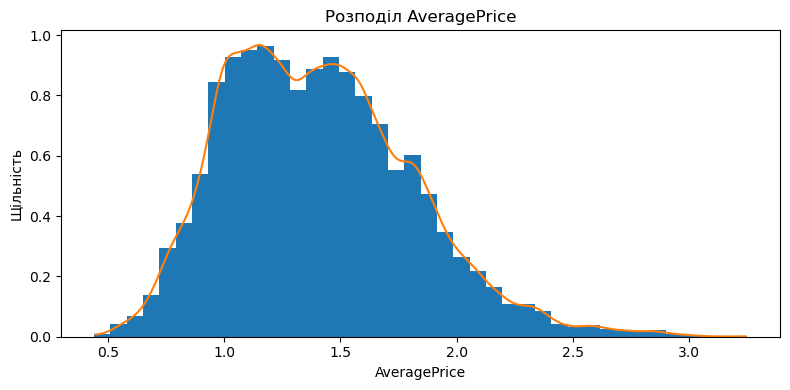

In [5]:
# Розподіл AveragePrice

plt.figure(figsize=(8,4))
vals_series = df['AveragePrice'].dropna()
plt.hist(vals_series, bins=40, density=True)
vals, bins = np.histogram(vals_series, bins=200, density=True)
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(bin_centers, gaussian_filter1d(vals, sigma=3))
plt.title('Розподіл AveragePrice')
plt.xlabel('AveragePrice')
plt.ylabel('Щільність')
plt.tight_layout()
plt.show()

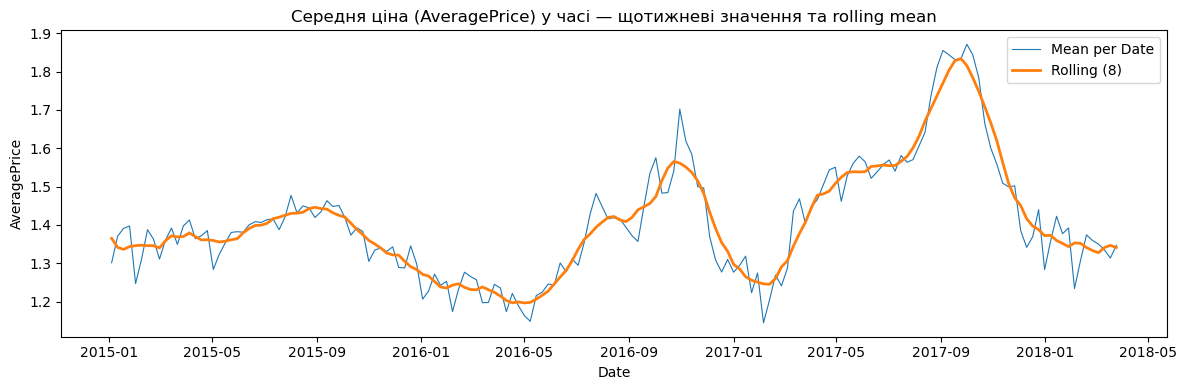

In [6]:
# AveragePrice протягом часу

plt.figure(figsize=(12,4))
price_by_date = df.groupby('Date')['AveragePrice'].mean()
plt.plot(price_by_date.index, price_by_date.values, linewidth=0.8, label='Mean per Date')
rolling = price_by_date.rolling(window=8, center=True, min_periods=1).mean()
plt.plot(rolling.index, rolling.values, linewidth=2, label='Rolling (8)')
plt.title('Середня ціна (AveragePrice) у часі — щотижневі значення та rolling mean')
plt.xlabel('Date')
plt.ylabel('AveragePrice')
plt.legend()
plt.tight_layout()
plt.show()

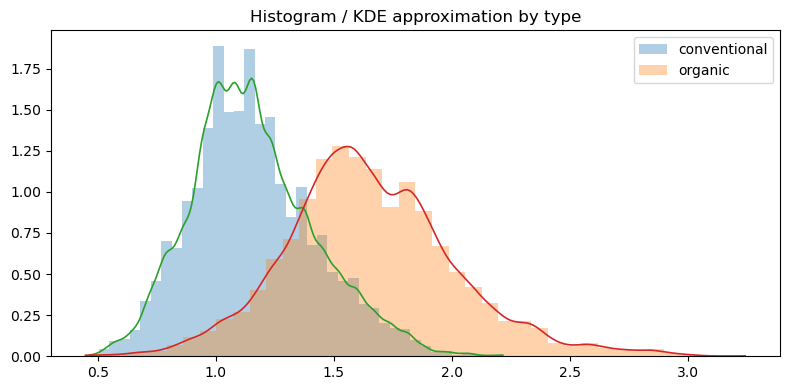

In [7]:
plt.figure(figsize=(8,4))
for t in types_sorted:
    s = df[df['type'] == t]['AveragePrice'].dropna()
    if s.empty: 
        continue
    plt.hist(s, bins=40, density=True, alpha=0.35, label=labels.get(t, str(t)))

for t in types_sorted:
    s = df[df['type'] == t]['AveragePrice'].dropna()
    if s.empty:
        continue
    vals, bins = np.histogram(s, bins=200, density=True)
    centers = (bins[:-1] + bins[1:]) / 2
    plt.plot(centers, gaussian_filter1d(vals, sigma=3), linewidth=1.2)

plt.legend()
plt.title('Histogram / KDE approximation by type')
plt.tight_layout()
plt.show()

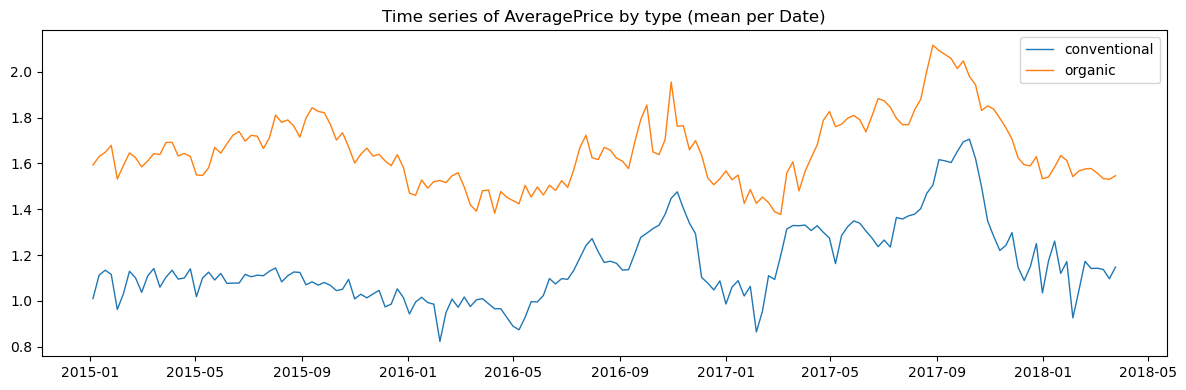

In [8]:
plt.figure(figsize=(12,4))
if 'Date' in df.columns:
    for t in types_sorted:
        ser = df[df['type'] == t].dropna(subset=['Date','AveragePrice']).groupby('Date')['AveragePrice'].mean()
        if ser.empty:
            continue
        plt.plot(ser.index, ser.values, linewidth=1, label=labels.get(t, str(t)))
    plt.legend()
    plt.title('Time series of AveragePrice by type (mean per Date)')
    plt.tight_layout()
    plt.show()
else:
    print("No 'Date' column found.")

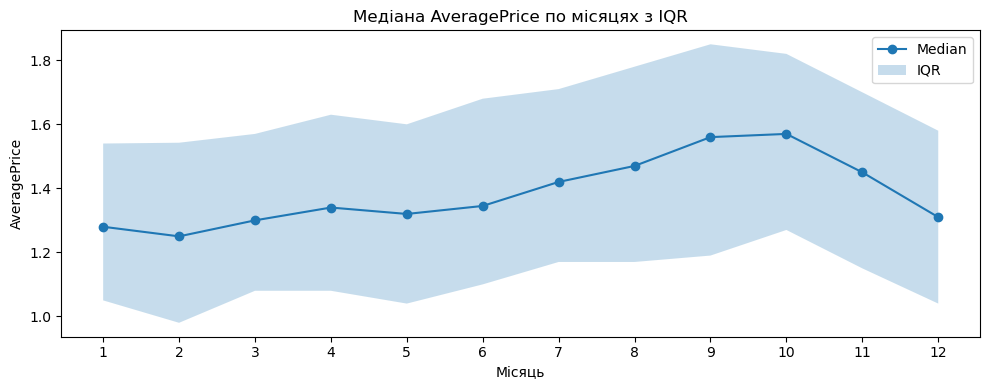

In [9]:
if 'month' in df.columns:
    monthly = df.groupby('month')['AveragePrice'].agg(['median','count'])
    q1 = df.groupby('month')['AveragePrice'].quantile(0.25)
    q3 = df.groupby('month')['AveragePrice'].quantile(0.75)
    monthly['q1'] = q1
    monthly['q3'] = q3

    plt.figure(figsize=(10,4))
    months = monthly.index
    plt.plot(months, monthly['median'], marker='o', label='Median')
    plt.fill_between(months, monthly['q1'], monthly['q3'], alpha=0.25, label='IQR')
    plt.xticks(range(1,13))
    plt.xlabel('Місяць')
    plt.ylabel('AveragePrice')
    plt.title('Медіана AveragePrice по місяцях з IQR')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No 'month' column — створіть її з Date перед запуском.")

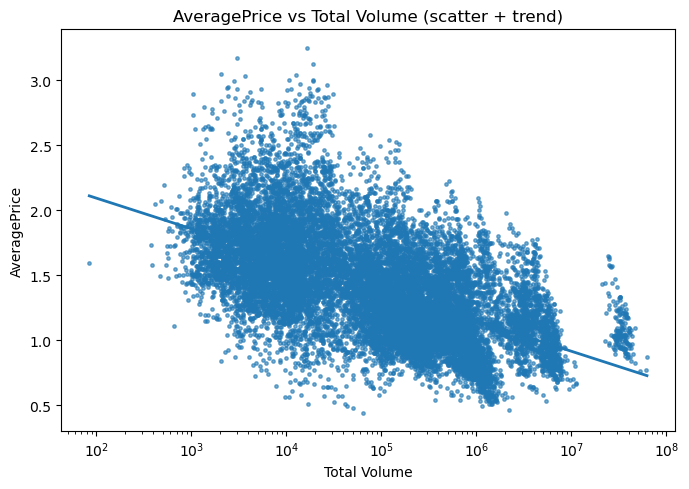

In [10]:
plt.figure(figsize=(7,5))
mask = df['Total Volume'].notna() & df['AveragePrice'].notna() & (df['Total Volume'] > 0)
if mask.any():
    x = df.loc[mask, 'Total Volume']
    y = df.loc[mask, 'AveragePrice']
    plt.scatter(x, y, s=6, alpha=0.6)
    z = np.polyfit(np.log1p(x), y, 1)
    xp = np.linspace(x.min(), x.max(), 100)
    plt.plot(xp, np.polyval(z, np.log1p(xp)), linewidth=2)
    plt.xscale('log')
    plt.title('AveragePrice vs Total Volume (scatter + trend)')
    plt.xlabel('Total Volume')
    plt.ylabel('AveragePrice')
    plt.tight_layout()
    plt.show()
else:
    print("No positive Total Volume data for scatter.")

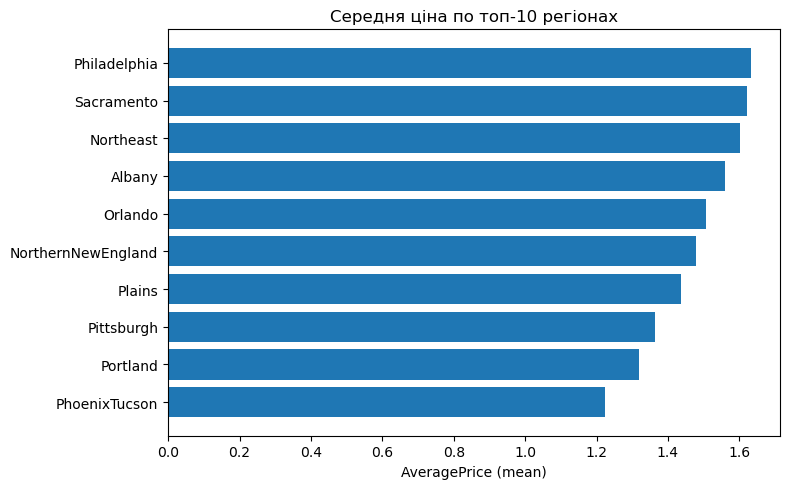

In [11]:
# Середня ціна по топ-10 регіонах
if 'region' in df.columns:
    top_regions = df['region'].value_counts().nlargest(10).index.tolist()
    mean_by_region = df[df['region'].isin(top_regions)].groupby('region')['AveragePrice'].mean().sort_values()
    if not mean_by_region.empty:
        plt.figure(figsize=(8,5))
        plt.barh(mean_by_region.index, mean_by_region.values)
        plt.xlabel('AveragePrice (mean)')
        plt.title('Середня ціна по топ-10 регіонах')
        plt.tight_layout()
        plt.show()
    else:
        print("Mean by region empty.")
else:
    print("No 'region' column.")


Числові колонки: ['AveragePrice', 'Total Volume', 'PLU_4046', 'PLU_4225', 'PLU_4770', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags']


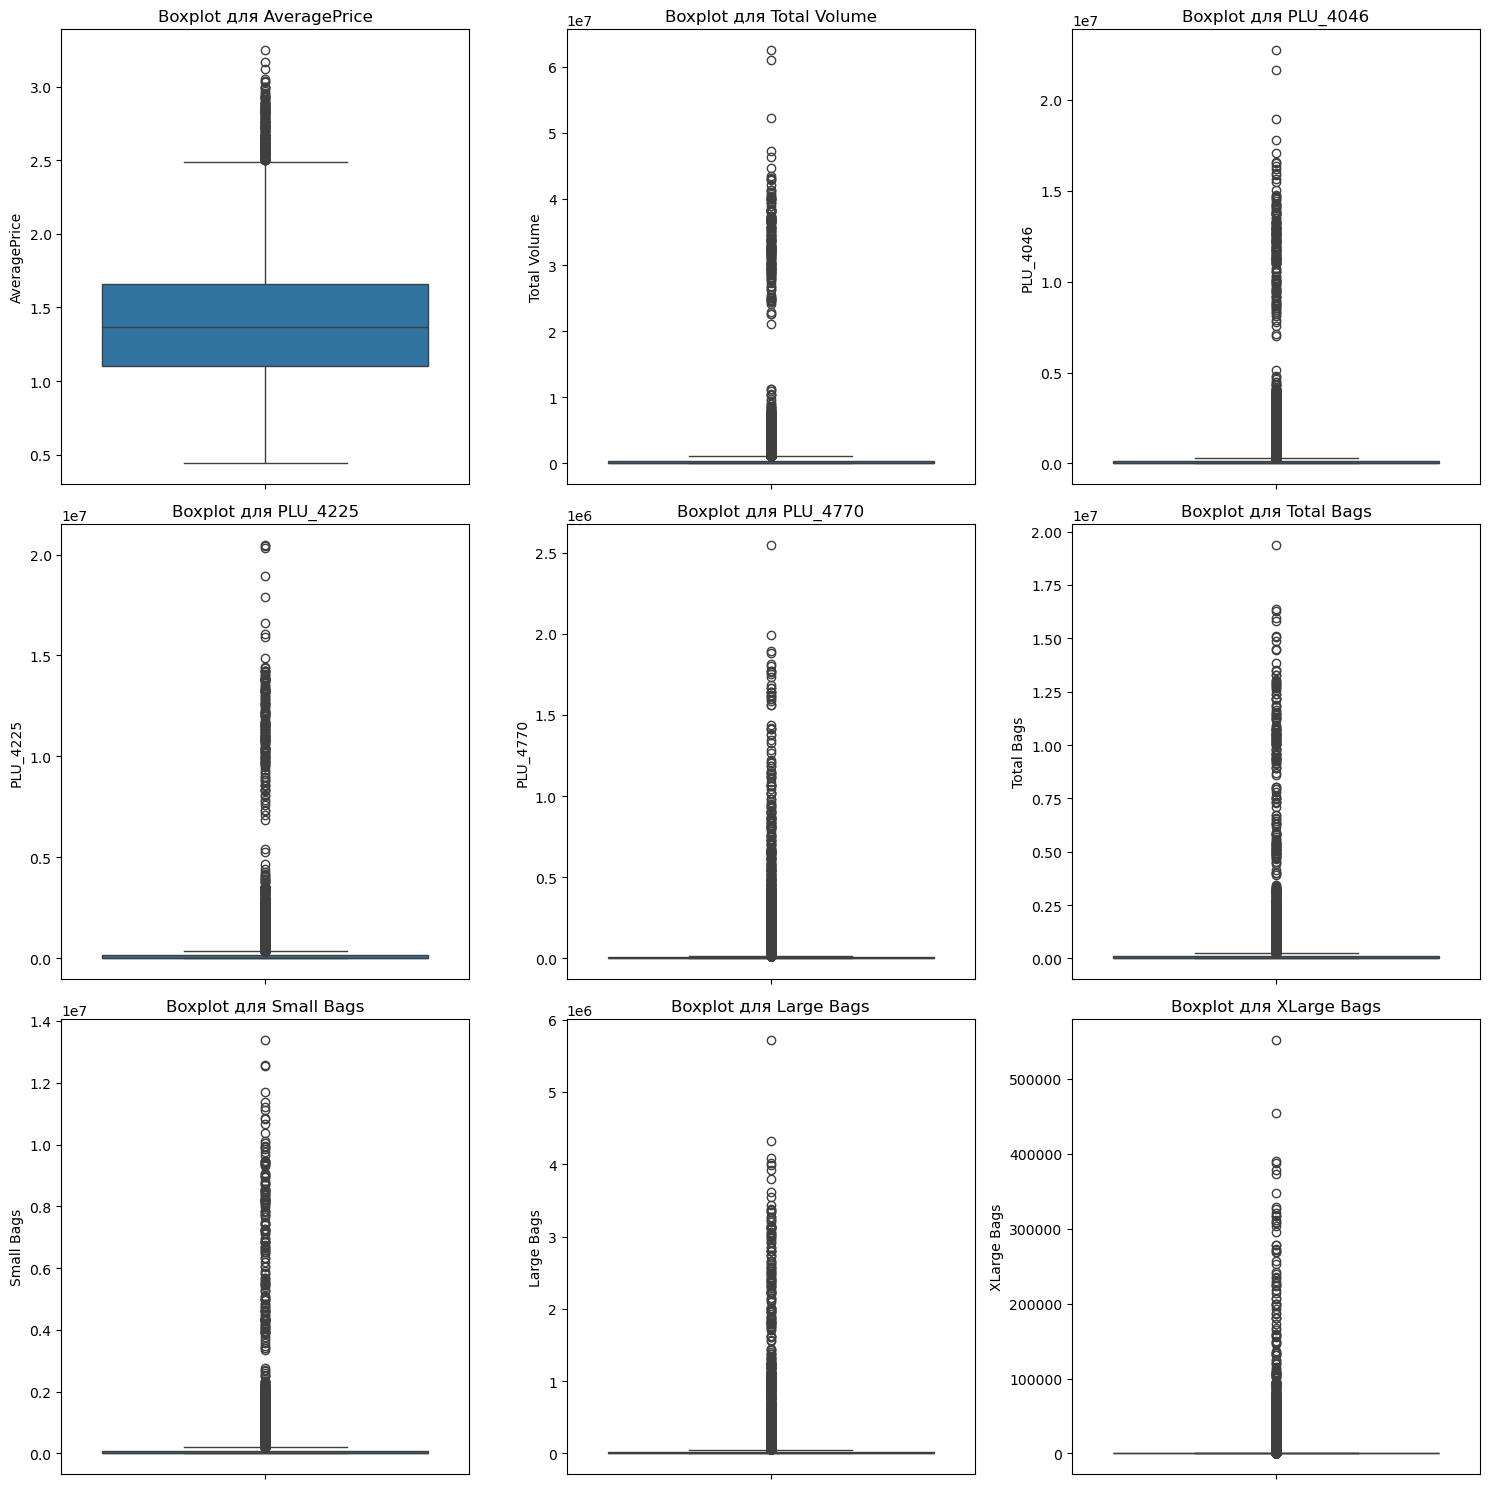

In [12]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
numeric_cols = numeric_cols.drop(['year', 'type', 'month', 'week', 'month_sin', 'month_cos'], errors='ignore')  # Виключити 'year', якщо вона є
# Виведення списку числових колонок для перевірки
print("Числові колонки:", list(numeric_cols))

# Створення subplot для кожного boxplot (наприклад, 3x4 сітка, залежно від кількості колонок)
num_cols = len(numeric_cols)
nrows = (num_cols + 2) // 3  # Автоматичний розрахунок рядків для 3 колонок у рядку
fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(15, 5 * nrows))
axes = axes.flatten()  # Перетворення в 1D масив для зручності

# Цикл для створення boxplot для кожної числової колонки
for i, col in enumerate(numeric_cols):
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot для {col}')
    axes[i].set_ylabel(col)

# Приховування зайвих axes, якщо є
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

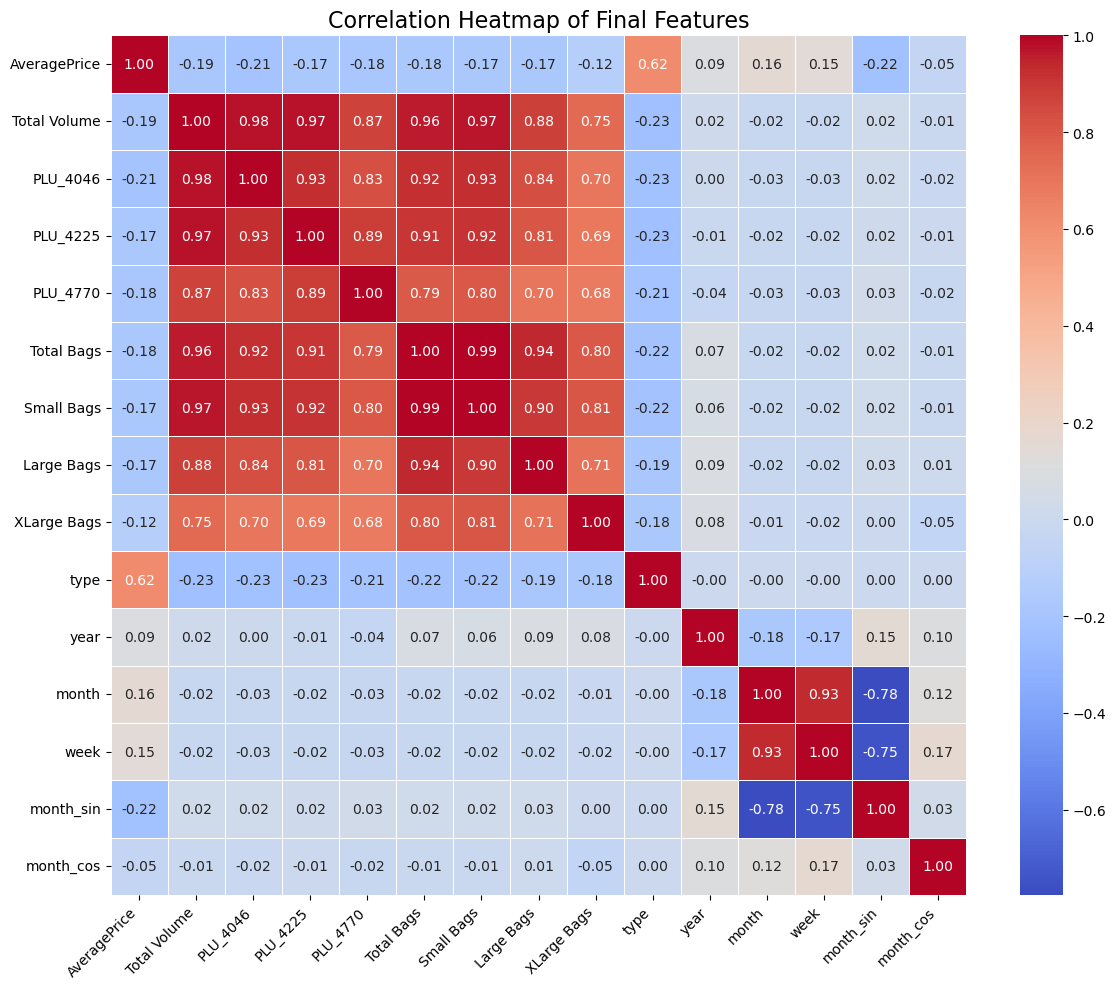

In [13]:
#Heatmap кореляційної матриці
numeric_df = df.select_dtypes(include=['number'])

# Розраховуємо повну матрицю кореляцій
corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 10)) # Adjust size for better readability

sns.heatmap(
    corr_matrix,
    annot=True,       # Display the correlation values on the map
    fmt='.2f',        # Format values to two decimal places
    cmap='coolwarm',  # Use a diverging colormap (blue-white-red)
    linewidths=.5     # Add lines to separate cells
)

plt.title('Correlation Heatmap of Final Features', fontsize=16)
plt.xticks(rotation=45, ha='right') # Rotate labels for better fit
plt.yticks(rotation=0)
plt.tight_layout() # Adjust plot to ensure everything fits without overlapping
plt.show()


In [14]:
unique_regions = sorted(df['region'].unique())
print(unique_regions)

['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston', 'BuffaloRochester', 'California', 'Charlotte', 'Chicago', 'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver', 'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton', 'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville', 'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale', 'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork', 'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia', 'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland', 'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento', 'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina', 'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse', 'Tampa', 'TotalUS', 'West', 'WestTexNewMexico']


In [15]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# --- 1. Initial Data Preparation (from your snippet) ---
data = df.copy()
data.columns = data.columns.str.strip()

# Drop unnecessary columns and unused aggregate regions
if 'Date' in data.columns:
    data.drop(columns=['Date', 'Total Volume', 'Total Bags', 'Unnamed: 0'], inplace=True, errors='ignore')
aggregate_regions = ['TotalUS', 'California', 'Northeast', 'SouthCentral', 'Southeast', 
                     'GreatLakes', 'Mideast', 'West', 'Plains']
data = data[~data['region'].isin(aggregate_regions)].reset_index(drop=True)

# --- 2. Feature Engineering & Transformation ---
# Add time-based features
# Note: The original 'Date' column was dropped, so we can't derive these.
# For demonstration, we'll create placeholder year/week/month.
# In a real scenario, you would derive these before dropping 'Date'.
data['year'] = np.random.choice([2015, 2016, 2017, 2018], size=len(data))
data['month'] = np.random.randint(1, 13, size=len(data))
data['week'] = np.random.randint(1, 53, size=len(data))
data['month_sin'] = np.sin(2 * np.pi * data['month']/12.0)
data['month_cos'] = np.cos(2 * np.pi * data['month']/12.0)

# Apply log transformation to skewed features
log_cols = ['PLU_4046', 'PLU_4225', 'PLU_4770', 'Small Bags', 'Large Bags', 'XLarge Bags']
for col in log_cols:
    data[col] = np.log1p(data[col])

# Rename columns to be valid identifiers
data.rename(columns={'Small Bags': 'Small_Bags', 
                     'Large Bags': 'Large_Bags', 
                     'XLarge Bags': 'XLarge_Bags'}, inplace=True)
                     
# --- 3. Outlier Removal ---
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Sequentially remove outliers
outlier_cols = ['AveragePrice', 'PLU_4046', 'PLU_4225', 'PLU_4770', 
                'Small_Bags', 'Large_Bags', 'XLarge_Bags']
initial_shape = data.shape
for col in outlier_cols:
    data = remove_outliers_iqr(data, col)
print(f"Data shape changed from {initial_shape} to {data.shape} after outlier removal.")


# --- 4. Define Features, Target, and Preprocessor ---
features = ['PLU_4046', 'PLU_4225', 'PLU_4770', 
            'Small_Bags', 'Large_Bags', 'XLarge_Bags',
            'type', 'region', 'year', 'week', 'month', 
            'month_sin', 'month_cos']

X = data[features]
y = data['AveragePrice']

# Split the data into an 80% main set (for training and CV) and a 20% hold-out set (for final validation)
# random_state ensures that the split is the same every time you run the code
X_main, X_holdout, y_main, y_holdout = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Verification ---
print("="*65)
print("Data Split into Main (Training/CV) and Hold-out (Final Test) Sets")
print("="*65)
print(f"Total initial samples: {len(X)}")
print(f"Main set for Training & CV (80%):      X_main shape: {X_main.shape}")
print(f"Hold-out set for Final Test (20%):   X_holdout shape: {X_holdout.shape}")
print("-" * 65)
print(f"Main set for Training & CV (80%):      y_main shape: {y_main.shape}")
print(f"Hold-out set for Final Test (20%):   y_holdout shape: {y_holdout.shape}")
print("="*65)

numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough' # Keep other columns if any
)

# --- 5. Apply Preprocessing Across All Folds ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Dictionary to store the preprocessed data for each fold
preprocessed_folds = {}

print("\n" + "="*80)
print("Applying Preprocessing to All Folds for Cross-Validation")
print("="*80)

for fold_idx, (train_index, test_index) in enumerate(kf.split(X, y)):
    # Step A: Split data into train and test sets for the current fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[test_index], y.iloc[test_index] # Corrected to use test_index for y_test

    # Step B: Fit the preprocessor on the TRAINING data and transform it
    # This learns the scaling parameters (mean, std) and encoding mappings ONLY from the training data
    X_train_preprocessed = preprocessor.fit_transform(X_train)

    # Step C: Transform the TEST data using the ALREADY FITTED preprocessor
    # This applies the learned parameters to the test set, preventing data leakage
    X_test_preprocessed = preprocessor.transform(X_test)

    # Store the results in the dictionary
    preprocessed_folds[f'fold_{fold_idx}'] = {
        'X_train': X_train_preprocessed,
        'y_train': y_train,
        'X_test': X_test_preprocessed,
        'y_test': y_test
    }
    
    # Step D: Print the results for this fold with enhanced formatting
    print(f"--- Fold {fold_idx+1}/5 ---")
    print(f"  Original shapes:      X_train: {str(X_train.shape):<15} | X_test: {str(X_test.shape):<15}")
    print(f"  Preprocessed shapes:  X_train: {str(X_train_preprocessed.shape):<15} | X_test: {str(X_test_preprocessed.shape):<15}")
    print(f"  Target shapes:        y_train: {str(y_train.shape):<15} | y_test: {str(y_test.shape):<15}\n")

print("="*80)
# Example of accessing the processed data for the first fold
print("Accessing data for Fold 0 from the dictionary:")
print(f"Shape of preprocessed training data: {preprocessed_folds['fold_0']['X_train'].shape}")
print("="*80)


Data shape changed from (15545, 14) to (14941, 14) after outlier removal.
Data Split into Main (Training/CV) and Hold-out (Final Test) Sets
Total initial samples: 14941
Main set for Training & CV (80%):      X_main shape: (11952, 13)
Hold-out set for Final Test (20%):   X_holdout shape: (2989, 13)
-----------------------------------------------------------------
Main set for Training & CV (80%):      y_main shape: (11952,)
Hold-out set for Final Test (20%):   y_holdout shape: (2989,)

Applying Preprocessing to All Folds for Cross-Validation
--- Fold 1/5 ---
  Original shapes:      X_train: (11952, 13)     | X_test: (2989, 13)     
  Preprocessed shapes:  X_train: (11952, 57)     | X_test: (2989, 57)     
  Target shapes:        y_train: (2989,)         | y_test: (2989,)        

--- Fold 2/5 ---
  Original shapes:      X_train: (11953, 13)     | X_test: (2988, 13)     
  Preprocessed shapes:  X_train: (11953, 57)     | X_test: (2988, 57)     
  Target shapes:        y_train: (2988,)   

In [16]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# Пайплайн з моделлю
svr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svr', SVR(kernel='poly', gamma='scale'))
])

# Grid для пошуку
param_grid = {
    'svr__degree': [2, 3],  # Поліноми 2-3
    'svr__epsilon': [0.01, 0.1],
    'svr__C': [0.01, 1, 100]
}

# GridSearch з 5-fold CV
grid_search = GridSearchCV(
    svr_pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1
)
grid_search.fit(X, y)

# Найкраща модель
best_model = grid_search.best_estimator_
print(f"Найкращі параметри: {grid_search.best_params_}")
print(f"Найкращий CV R²: {grid_search.best_score_:.4f}")

# Прогноз на всьому датасеті
y_pred = best_model.predict(X)
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)
print(f"Загальна оцінка: MAE={mae:.4f}, RMSE={rmse:.4f}, R²={r2:.4f}")

# Збереження моделі
joblib.dump(best_model, 'best_svr_avocado.pkl')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Найкращі параметри: {'svr__C': 1, 'svr__degree': 2, 'svr__epsilon': 0.1}
Найкращий CV R²: 0.2177
Загальна оцінка: MAE=0.1586, RMSE=0.2130, R²=0.6956


['best_svr_avocado.pkl']